In [16]:
%matplotlib inline
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

## Useful functions that may help you

In [56]:
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(float) / info.max # Divide all values by the largest possible value in the datatype

### Functions that might be helpful ###

def im2col_sliding(A, BSZ, stepsize=1):
    # This function is similar to the `im2col` function from MATLAB. It rearrange image blocks into columns.
    # 
    # Paste the following command to a coding block and check out the results to get more intuitions!
    # r = np.arange(25).reshape(5, 5); s = (3, 3); print(im2col_sliding(r, s).shape); print(im2col_sliding(r, s))

    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1
    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols    

In [57]:
r = np.arange(25).reshape(5, 5)
s = (3, 3)
print(r)
print(im2col_sliding(r, s).shape)
print(im2col_sliding(r, s))

[[ 0  1  2  3  4]
 [ 5  6  7  8  9]
 [10 11 12 13 14]
 [15 16 17 18 19]
 [20 21 22 23 24]]
(9, 9)
[[ 0  1  2  5  6  7 10 11 12]
 [ 1  2  3  6  7  8 11 12 13]
 [ 2  3  4  7  8  9 12 13 14]
 [ 5  6  7 10 11 12 15 16 17]
 [ 6  7  8 11 12 13 16 17 18]
 [ 7  8  9 12 13 14 17 18 19]
 [10 11 12 15 16 17 20 21 22]
 [11 12 13 16 17 18 21 22 23]
 [12 13 14 17 18 19 22 23 24]]


## Get the images

In [58]:
r = requests.get("http://6.869.csail.mit.edu/sp22/pset7/rings.jpg", timeout=0.5)
if r.status_code == 200:
    with open("rings.jpg", 'wb') as f:
        f.write(r.content)

## "find_matches" function

In [62]:
def find_matches(template, sample, G):


    ### Note: below is just a provided sketch, you can have your own code flow 
    ### parameters, as used by Efros and Leung
    epsilon = 0.1
    delta = 0.3
    
    #### TODO:
    # 1. construct validMask is a square mask of width w that is 1 where template is filled
    # 2. multiply validMask by G. Make sure the result is normalized to sum to 1. 
    # 3. unfold the result to a column vector (you can use x.ravel(order='F') for column-major order)

    # 1. Construct validMask is a square mask of width w that is 1 where template is filled
    validMask = np.where(template != 0, 1, 0)

    # 2. Multiply validMask by G for each channel separately.
    Mask = validMask * G
    # Make sure the result is normalized to sum to 1.
    Mask /= (np.sum(Mask) + 1e-8)

    # 3. Unfold the result to a column vector
    # (you can use x.ravel(order='F') for column-major order)
    column_vector = Mask.ravel(order='F')[:, None]

    #### TODO:
    # Play with im2col_sliding()! 
    # partition sample to blocks (represented by column vectors). 
    # We can actually do this only once, and pass this representation to this 
    # function, but we leave it as is in order not to change function signature 
    # that was instructed.
    # 1. create a 2D feature matrix of size [template.size, nBlocks] containing 
    # the unfolded sample patches (you will need to concatenate channels for an RGB image)
    # 2. unfold the template to a column vector (you can use x.ravel(order='F') for column-major order)

    # 1. Create a 2D feature matrix of size [template.size, nBlocks] containing 
    # the unfolded sample patches (you will need to concatenate channels for an RGB image)
    block_shape = template.shape
    sample_blocks_r = im2col_sliding(sample[:, :, 0], block_shape[:2])
    sample_blocks_g = im2col_sliding(sample[:, :, 1], block_shape[:2])
    sample_blocks_b = im2col_sliding(sample[:, :, 2], block_shape[:2])

    blocks = sample_blocks_r.shape[1]
    sample_blocks = np.zeros((np.prod(block_shape), blocks))
    for i in range(blocks):
        sample_blocks[:, i] = np.concatenate([sample_blocks_r[:, i], sample_blocks_g[:, i], sample_blocks_b[:, i]])

    # 2. Unfold the template to a column vector (you can use x.ravel(order='F') for column-major order)
    template_vector = template.ravel(order='F')

    #### TODO:
    # 1. write vectorized code to calculate SSD error (remember to mask them) for all unfolded patches
    # 2. find the best blocks according to the thresholds listed in the pdf
    # 3. extract the center pixel value (3 numbers for RGB) of the best blocks
    # as best_matches. best_matches should have shape [3, number_of_best_blocks]

    # 1. Write vectorized code to calculate SSD error (remember to mask them) for all unfolded patches
    errors = np.nansum(column_vector * (sample_blocks - template_vector[:, np.newaxis]) ** 2, axis=0)

    # 2. Find the best blocks according to the thresholds listed in the PDF
    threshold = (1 + epsilon) * np.min(errors)
    possible_indices = np.where(errors <= min(delta, threshold))[0]

    # 3. Extract the center pixel value (3 numbers for RGB) of the best blocks
    # as best_matches. best_matches should have shape [3, number_of_best_blocks]
    center_location = block_shape[0] * block_shape[1] // 2
    best_matches = np.hstack((sample_blocks_r[center_location, possible_indices], sample_blocks_g[center_location, possible_indices], sample_blocks_b[center_location, possible_indices]))
    
    return best_matches, errors

## "Synth_texture" function


In [72]:
def synth_texture(sample, w, s):
    ###Texture Synthesis by Non-parameteric Sampling / Efros and Leung
    ###Note: below is just a provided sketch, you can have your own code flow
    
    ## Normalizing pixel intensity
    sample = im2double(sample)
    seed_size = 3
    [sheight, swidth, nChannels] = sample.shape
    theight = s[0]
    twidth = s[1]
    synthIm = np.full((theight, twidth, nChannels),np.nan)

    ### TODO: Fill in mu, sigma, G
    ### G is a centered 2D Gaussian with standard deviation w/6.4 sampled on a w x w grid
    ### This is similar to what you did on pset 2! 
    sigma = w / 6.4
    n = np.arange(0, w) - (w-1) / 2
    sig2 = 2 * sigma ** 2
    tmp_gauss = np.exp(-n ** 2 / sig2)
    
    G = np.outer(tmp_gauss, tmp_gauss)
    G = np.repeat(G[:, :, np.newaxis], nChannels, axis=2)

    ### Initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image.
    ### Just for convenience, keep some space (SEED_SIZE) from the boundary
    i0=31; j0=3
    # i0 = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    # j0 = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    c = [round(.5 * x) for x in s]
    synthIm[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ,:] = sample[i0: i0 + seed_size , j0: j0 + seed_size,:]
     
    ### bitmap indicating filled pixels
    filled = np.zeros(s)
    filled[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ] = 1
    n_filled = int(np.sum(filled))
    n_pixels = s[0]*s[1]

    ### Main Loop
    next_p = n_pixels / 10
    while(n_filled < n_pixels):
        # report progress
        if(n_filled > next_p):
            print( round(100 * n_filled / n_pixels), '% complete', )
            next_p += n_pixels / 10
            
        ### dilate current boundary, find the next round of un-filled pixels
        ### (ii, jj) represents the locations
        border = ndimage.binary_dilation(filled).astype(filled.dtype) - filled
        ii, jj = np.where(border == 1)     
       
        ### Permute (just to insert some random noise, not a must, but recommended. play with it!)
        #perm = np.random.permutation(len(ii))
        #ii = ii[perm]
        #jj = jj[perm]        

        for i in range(len(ii)):
            ### Place window at the center of the current pixel to extract
            ### the template patch
            ic = [x for x in range(math.ceil(ii[i] - w/2), math.floor(ii[i] + w / 2)+1)]
            ic = np.asarray(ic)
            jc = [x for x in range(math.ceil(jj[i] - w/2), math.floor(jj[i] + w / 2)+1)]
            jc = np.asarray(jc)
            inbounds_ic = (ic >= 0) & (ic< theight)
            inbounds_jc = (jc >=0) & (jc < twidth)
            template = np.full((w, w, nChannels), np.nan)

            nix_1 = np.ix_(np.nonzero(inbounds_ic)[0],np.nonzero(inbounds_jc)[0])
            nix_2 = np.ix_(ic[inbounds_ic],jc[inbounds_jc])
            template[nix_1] = synthIm[nix_2]

            ### Call find_matches() to get the best matches from the src image.
            [best_matches, errors] = find_matches(template, sample, G)           
        
            ### TODO:
            ### Sample from best matches and update synthIm
            idx = np.arange(best_matches.shape[0])
            rand_index = np.random.choice(idx)
            synthIm[ii[i], jj[i], :] = best_matches[rand_index]

            ### update bitmap indicating the corresponding pixel is filled
            filled[ii[i], jj[i]] = 1
            n_filled = n_filled + 1            
            
    return synthIm

## main function

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


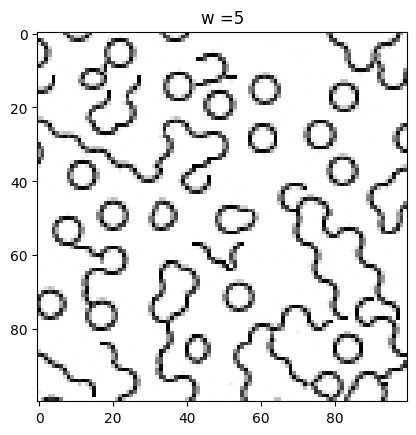

In [74]:
source = cv2.imread('rings.jpg')
w = 5
target = synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


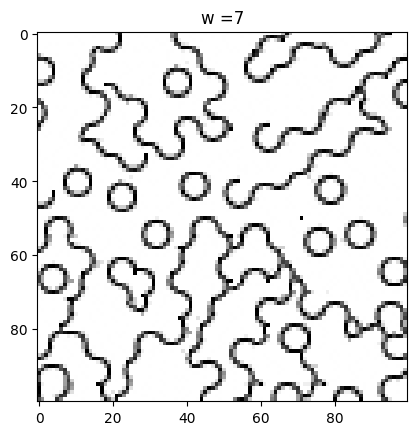

In [75]:
source = cv2.imread('rings.jpg')
w = 7
target = synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


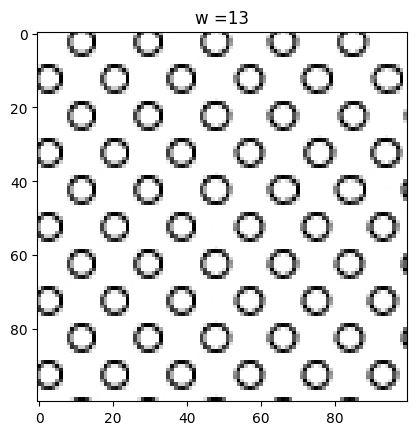

In [76]:
source = cv2.imread('rings.jpg')
w = 13
target = synth_texture(source, w, [100, 100])

plt.imshow(target)
plt.title('w =' + str(w))
plt.show()

**Comments about algorithm performance with respect to window size:**

Clearly we see that for $w=13$, the synthetized texture is closest to this original texture as a larger window size captures more spatial information about the original texture.

In the texture synthesis algorithm, the window width (w) determines the size of the template used for finding matches between the original and synthesized texture. A larger window size means that the algorithm considers a bigger neighborhood of pixels, which allows it to better capture the patterns and structures in the original texture.

When using a smaller window size, the algorithm may not be able to capture these patterns as effectively, leading to a less accurate representation of the original texture, like for window sizes $w=5$ and $w=7$. Here, $w=13$ provides the best results because it captures enough spatial information to reproduce the patterns present in the original image while maintaining computational efficiency.


10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


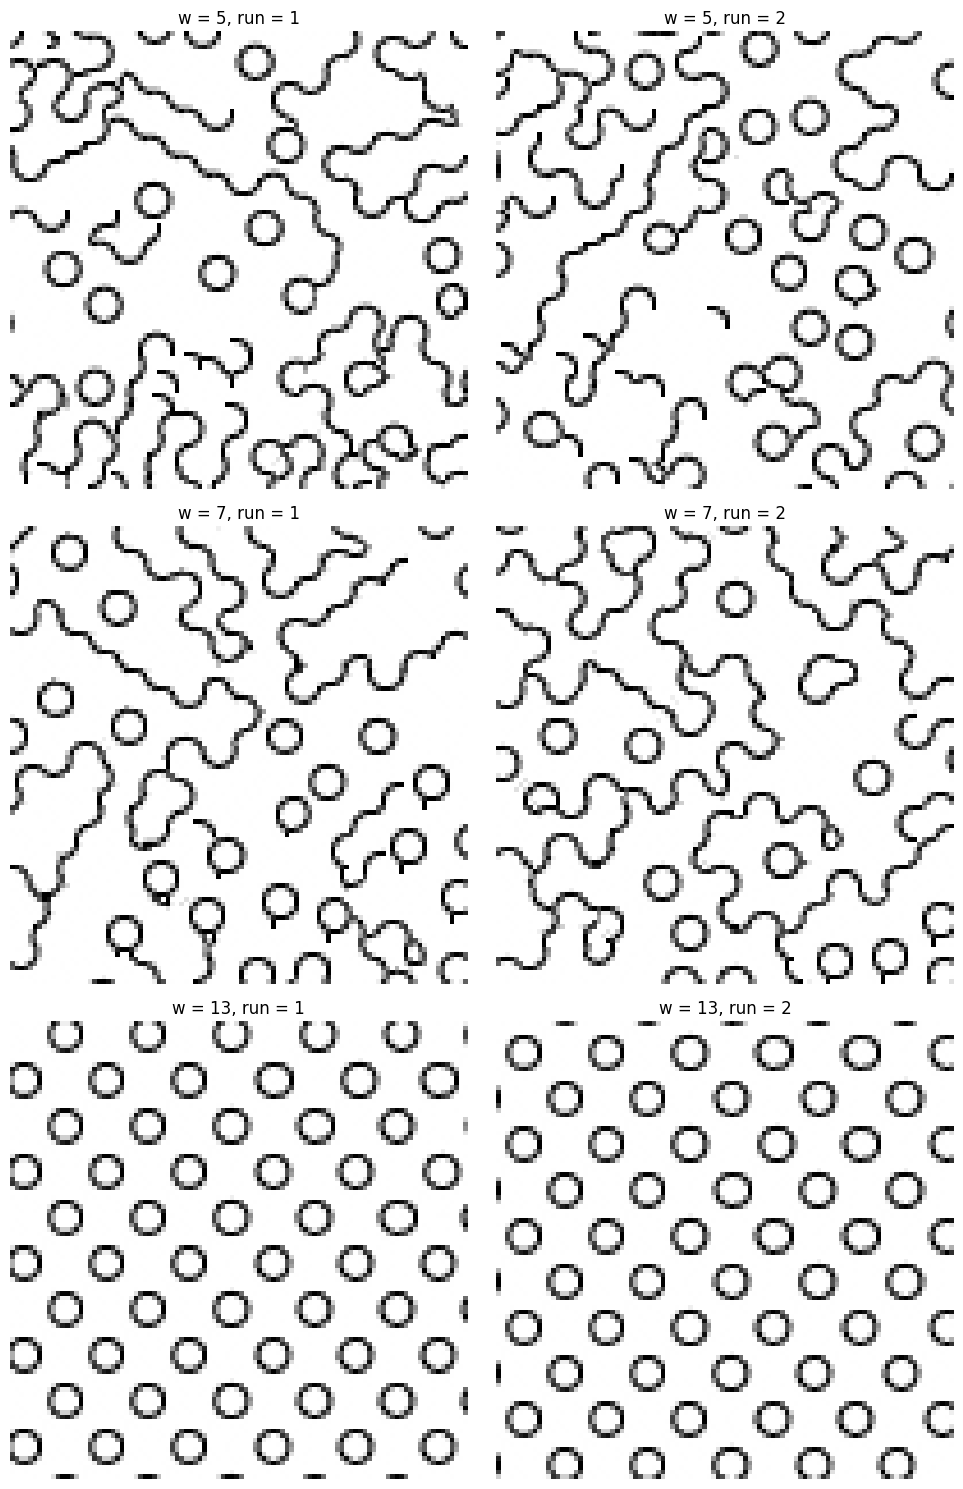

In [82]:
import matplotlib.pyplot as plt
import cv2

# Load the grayscale image
source = cv2.imread('rings.jpg')

# Set the window widths
window_widths = [5, 7, 13]

# Set the output size
s = [100, 100]

fig, axes = plt.subplots(len(window_widths), 2, figsize=(10, 5 * len(window_widths)))

for i, w in enumerate(window_widths):
    for run in range(2):
        target = synth_texture(source, w, s)
        axes[i, run].imshow(target, cmap='gray')
        axes[i, run].set_title(f'w = {w}, run = {run + 1}')
        axes[i, run].axis('off')

plt.tight_layout()
plt.show()


**Comments about for a given window size, re-runing the algorithm with the same starting seed**

Even though we are using the same starting seed for a given window size, we still get slightly different results due to the random sampling process in the texture synthesis algorithm.

When the algorithm searches for the best matches between the original and synthesized textures, it often finds several matches with similar error values. Instead of always choosing the same match, the algorithm randomly samples from the best matches. This random sampling introduces variability in the synthesized texture, which can result in slightly different results even when the starting seed is the same.

The random sampling is helpful because it promotes diversity in the synthesized texture and prevents overfitting to a specific pattern. However, it also means that the algorithm can produce slightly different results on each run, even when using the same starting seed.

Now if I force a numpy seed for reproducibility purposes, here are the results:


10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


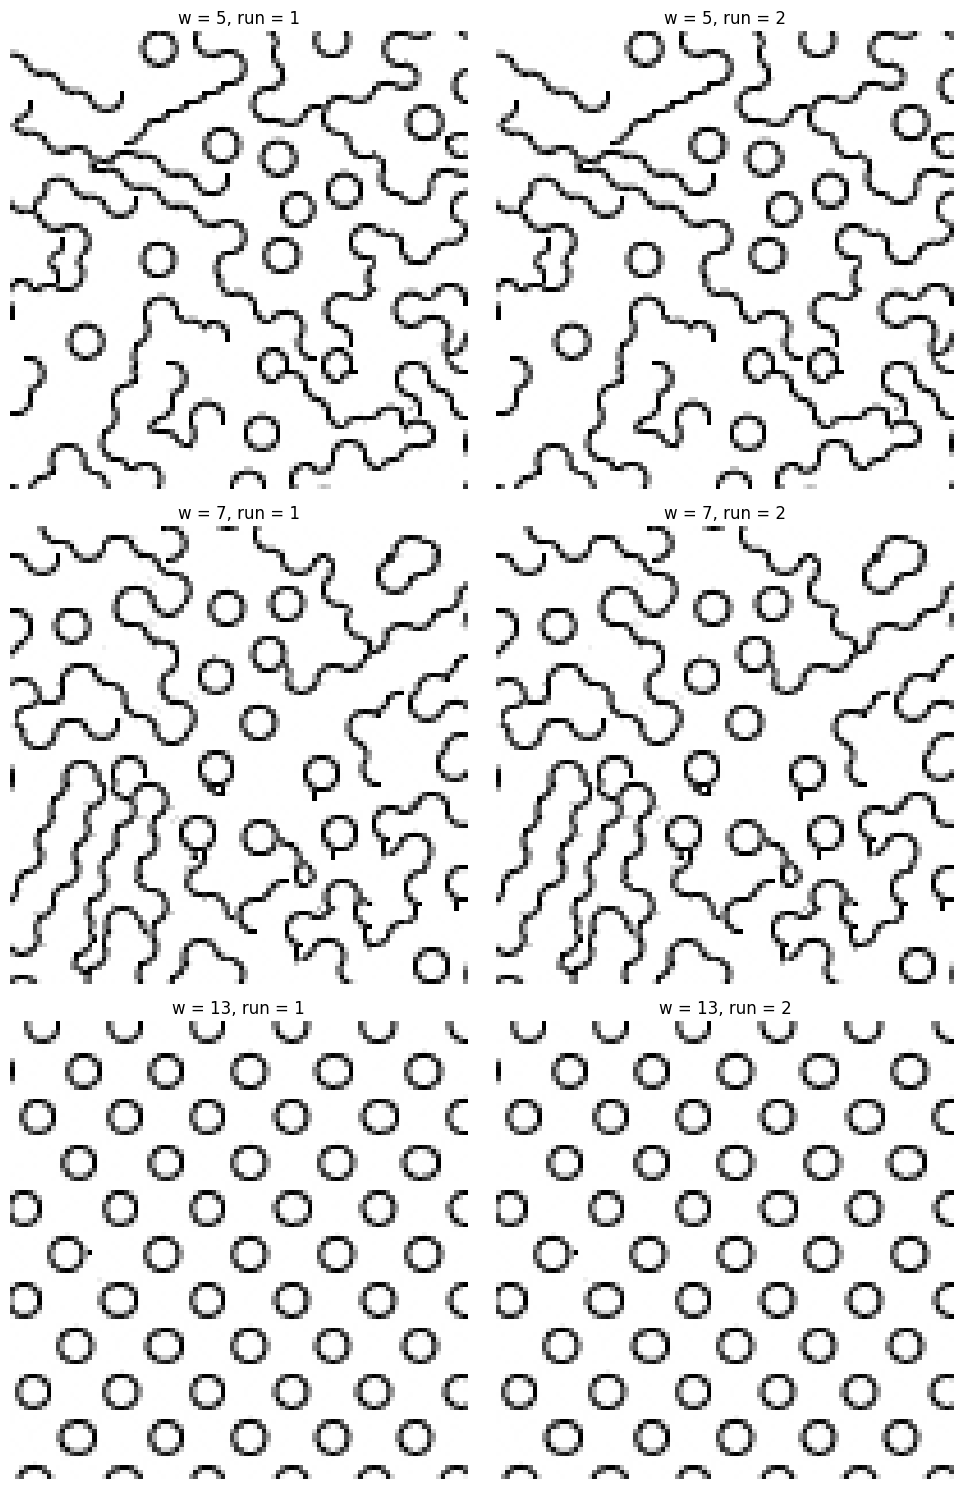

In [83]:
import matplotlib.pyplot as plt
import cv2

# Load the grayscale image
source = cv2.imread('rings.jpg')

# Set the window widths
window_widths = [5, 7, 13]

# Set the output size
s = [100, 100]

fig, axes = plt.subplots(len(window_widths), 2, figsize=(10, 5 * len(window_widths)))

for i, w in enumerate(window_widths):
    for run in range(2):
        np.random.seed(77777)
        target = synth_texture(source, w, s)
        axes[i, run].imshow(target, cmap='gray')
        axes[i, run].set_title(f'w = {w}, run = {run + 1}')
        axes[i, run].axis('off')

plt.tight_layout()
plt.show()


Now that we've set a numpy seed, the random choice happening to pick the best match is always the same.